Dimensions : (12338, 11)

Colonnes et types :
 titre                                                                                                                                                                                                                                                                                                       object
prix                                                                                                                                                                                                                                                                                                       float64
disponibilite                                                                                                                                                                                                                                                                                               object
note_moyenne                    

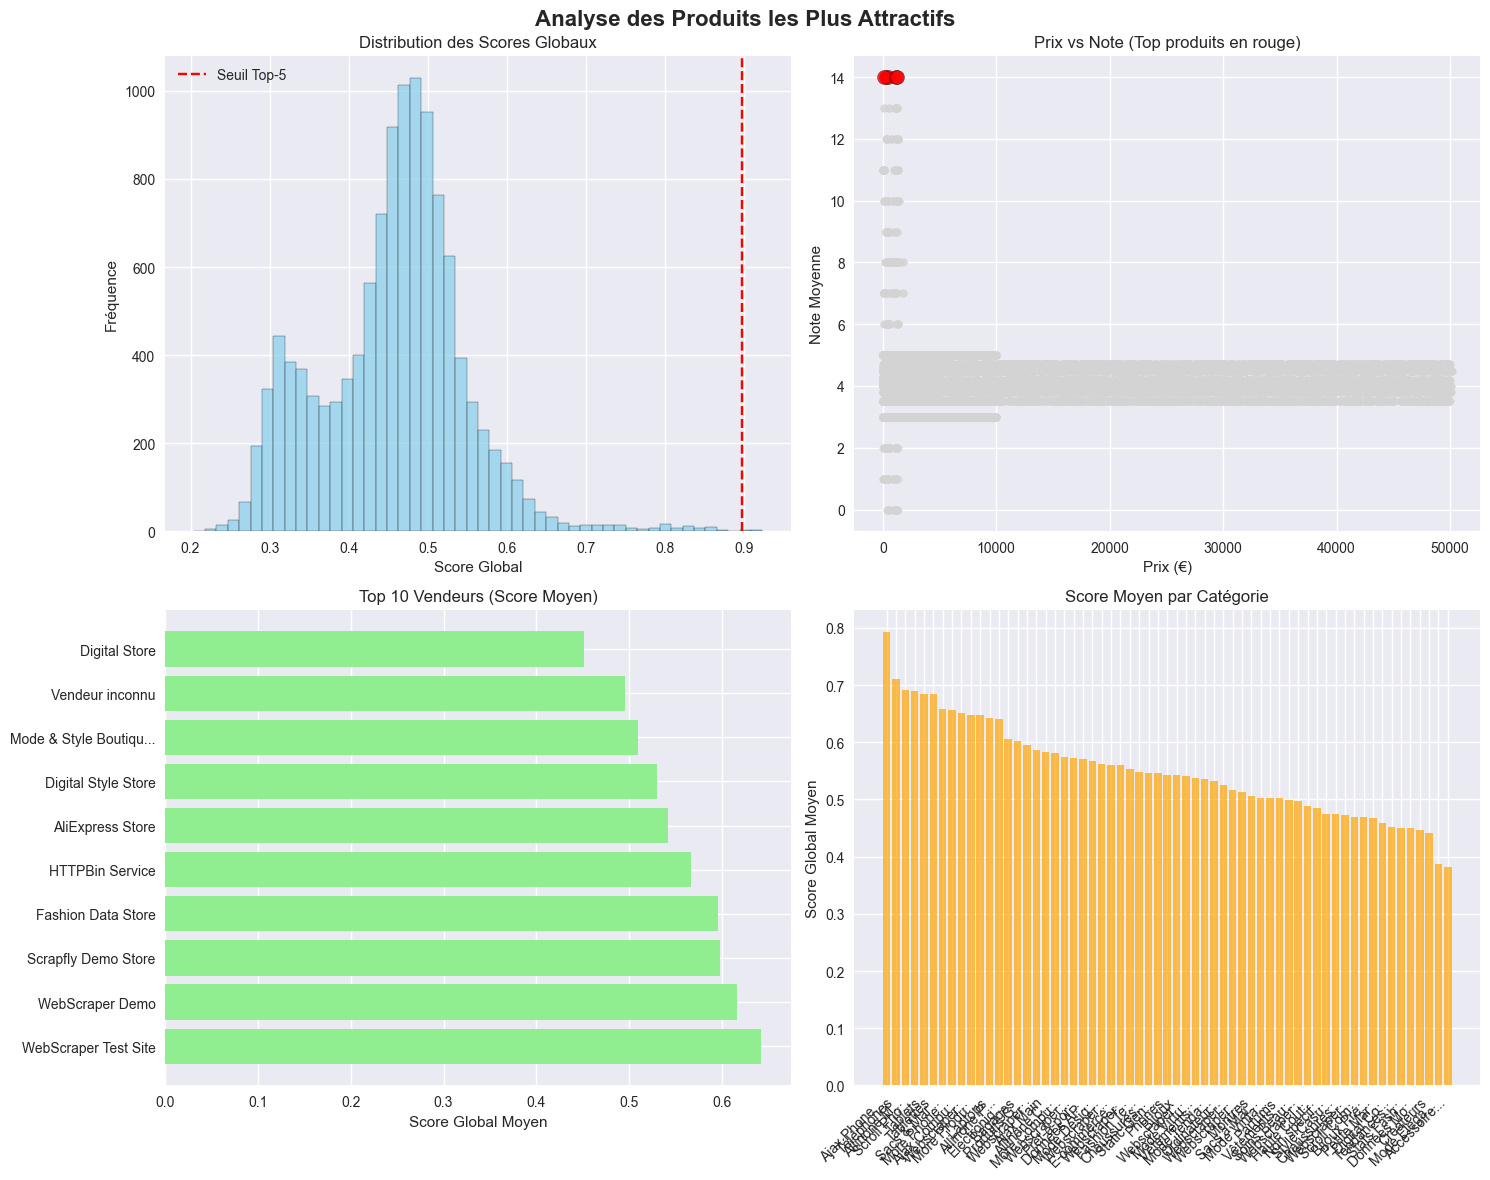


=== ANALYSE PAR VENDEUR ===
Top 10 vendeurs par score moyen :
                       Score_Moyen  Nb_Produits  Meilleur_Score  Prix_Moyen  \
vendeur                                                                       
WebScraper Test Site         0.642          177           0.923       0.015   
WebScraper Demo              0.616           60           0.888       0.012   
Scrapfly Demo Store          0.598           30           0.704       0.001   
Fashion Data Store           0.596            1           0.596       0.002   
HTTPBin Service              0.567            2           0.569       0.249   
AliExpress Store             0.542            1           0.542       0.249   
Digital Style Store          0.530           10           0.649       0.001   
Mode & Style Boutique        0.509           45           0.679       0.003   
Vendeur inconnu              0.495          200           0.862       0.130   
Digital Store                0.451         5200           0.627     

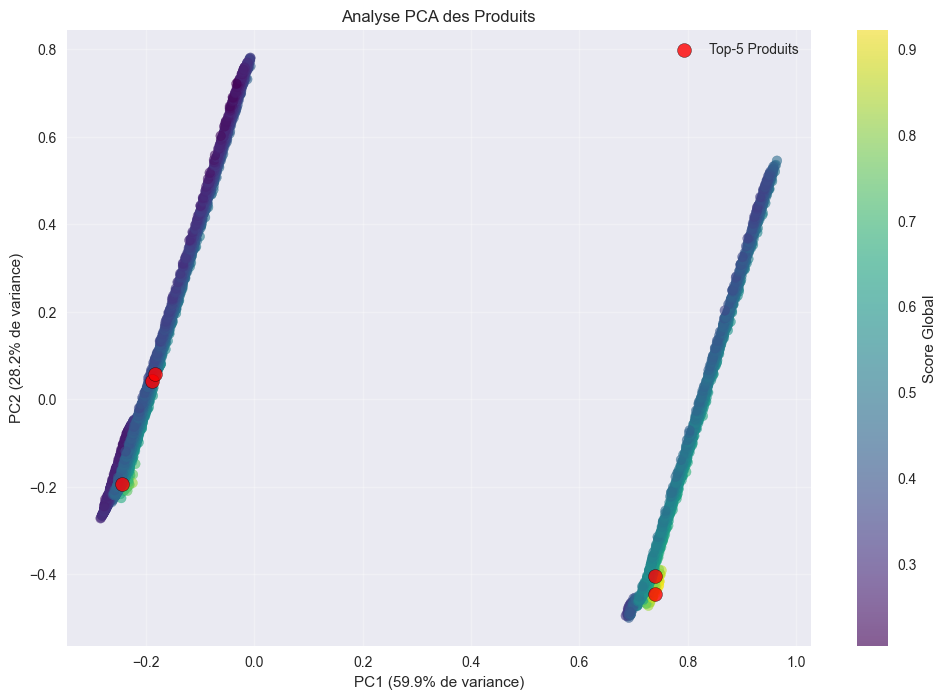


=== CLUSTERING K-MEANS ===
Analyse des clusters :
         score_global   prix  note_moyenne  ventes_estimees
cluster                                                    
0               0.360  0.706         0.294            0.613
1               0.321  0.096         0.220            0.173
2               0.585  0.114         0.330            0.585
3               0.483  0.114         0.302            0.615
4               0.461  0.701         0.294            0.611


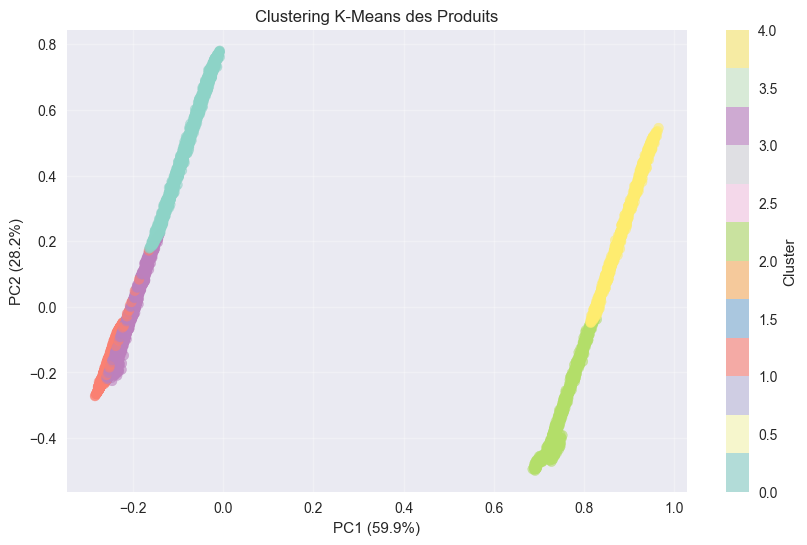


=== MODÈLE PRÉDICTIF RANDOM FOREST ===
R² Score: 0.998
RMSE: 0.004

Importance des caractéristiques :
           feature  importance
2  ventes_estimees    0.358989
0             prix    0.343118
3      dispo_score    0.208904
1     note_moyenne    0.088989


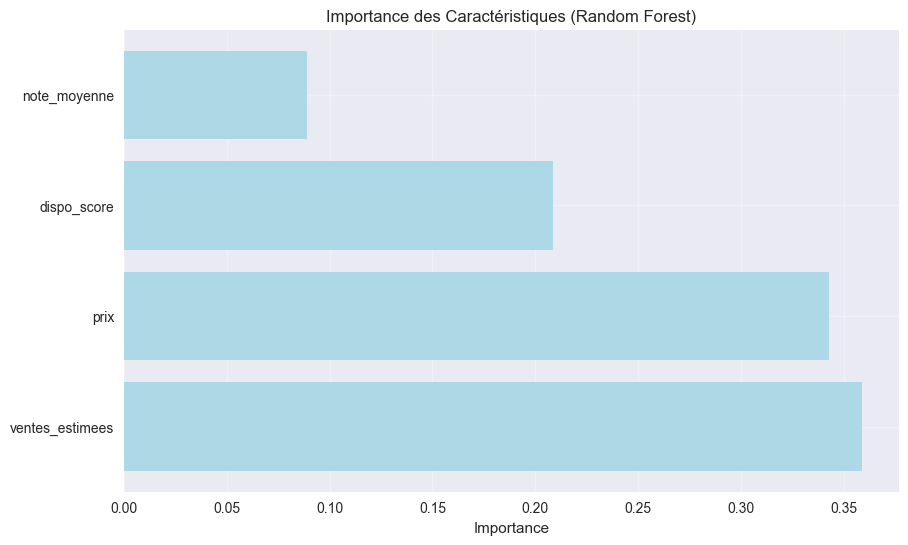


=== TABLEAU RÉCAPITULATIF FINAL ===
   titre    prix  note_moyenne              vendeur categorie disponibilite  score_global
 $295.99  295.99          14.0 WebScraper Test Site   Laptops      En stock      0.922708
 $488.78  488.78          14.0 WebScraper Test Site Ajax Main      En stock      0.912983
 $107.99  107.99          14.0 WebScraper Test Site   Tablets      En stock      0.910025
$1187.98 1187.98          14.0 WebScraper Test Site   Laptops      En stock      0.901238
 $1239.2 1239.20          14.0 WebScraper Test Site   Laptops      En stock      0.896556


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Chargement des données
df = pd.read_csv('produits_scrapy.csv', sep=';')

# 2. Aperçu général
print("Dimensions :", df.shape)
print("\nColonnes et types :\n", df.dtypes)
print("\nExtrait des données :\n", df.head())
print("\nValeurs manquantes par colonne :\n", df.isnull().sum())

# 3. Nettoyage des données
# Remplacer les valeurs manquantes numériques par la moyenne
df['prix'].fillna(df['prix'].mean(), inplace=True)
df['note_moyenne'].fillna(df['note_moyenne'].mean(), inplace=True)

# Remplacer les valeurs manquantes textuelles par défaut
df['description'].fillna('Description non disponible', inplace=True)
df['vendeur'].fillna('Vendeur inconnu', inplace=True)
df['categorie'].fillna('Non spécifiée', inplace=True)
df['disponibilite'].fillna('Inconnu', inplace=True)

print("\nValeurs manquantes après traitement :\n", df.isnull().sum())

# Suppression des doublons
print("Nombre de doublons :", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Nouvelle taille du dataset :", df.shape)

# 4. Préparation des données pour l'analyse
# Créer une variable 'ventes_estimees' basée sur la note et la disponibilité
# (simulation car pas de données de ventes réelles)
np.random.seed(42)
df['ventes_estimees'] = np.where(
    df['note_moyenne'] > 3,
    np.random.poisson(lam=50, size=len(df)),
    np.random.poisson(lam=20, size=len(df))
)

# Créer un score de disponibilité numérique
availability_mapping = {
    'En stock': 1.0,
    'Stock limité': 0.7,
    'Rupture de stock': 0.0,
    'Inconnu': 0.5
}
df['dispo_score'] = df['disponibilite'].map(availability_mapping).fillna(0.5)

# 5. Normalisation des critères
scaler = MinMaxScaler()

# Sélectionner les colonnes numériques pour la normalisation
numeric_cols = ['prix', 'note_moyenne', 'ventes_estimees', 'dispo_score']
df_scaled = df.copy()

# Normaliser les données
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Pour le prix, on veut que les prix plus bas soient meilleurs (1 - prix_norm)
df_scaled['prix_inverse'] = 1 - df_scaled['prix']

print("\n=== NORMALISATION DES DONNÉES ===")
print("Statistiques des données normalisées :")
print(df_scaled[numeric_cols + ['prix_inverse']].describe())

# 6. Définition du score global composite
def calculate_composite_score(row, alpha=0.4, beta=0.2, gamma=0.3, delta=0.1):
    """
    Calcule le score composite pour un produit
    alpha: poids pour la note
    beta: poids pour le prix (inversé)
    gamma: poids pour les ventes
    delta: poids pour la disponibilité
    """
    score = (alpha * row['note_moyenne'] + 
             beta * row['prix_inverse'] + 
             gamma * row['ventes_estimees'] + 
             delta * row['dispo_score'])
    return score

# Appliquer le score composite
df_scaled['score_global'] = df_scaled.apply(calculate_composite_score, axis=1)

# 7. Top-K sélection (K=5)
K = 5
top_products = df_scaled.nlargest(K, 'score_global')

print(f"\n=== TOP {K} PRODUITS LES PLUS ATTRACTIFS ===")
for i, (idx, product) in enumerate(top_products.iterrows(), 1):
    print(f"\n{i}. {product['titre']}")
    print(f"   Score global: {product['score_global']:.3f}")
    print(f"   Prix: {df.loc[idx, 'prix']:.2f}€")
    print(f"   Note moyenne: {df.loc[idx, 'note_moyenne']:.1f}")
    print(f"   Vendeur: {product['vendeur']}")
    print(f"   Disponibilité: {df.loc[idx, 'disponibilite']}")

# 8. Visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analyse des Produits les Plus Attractifs', fontsize=16, fontweight='bold')

# Graphique 1: Distribution des scores
axes[0, 0].hist(df_scaled['score_global'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(top_products['score_global'].min(), color='red', linestyle='--', 
                   label=f'Seuil Top-{K}')
axes[0, 0].set_xlabel('Score Global')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des Scores Globaux')
axes[0, 0].legend()

# Graphique 2: Prix vs Note pour les top produits
scatter = axes[0, 1].scatter(df['prix'], df['note_moyenne'], alpha=0.6, c='lightgray', s=30)
top_scatter = axes[0, 1].scatter(df.loc[top_products.index, 'prix'], 
                                df.loc[top_products.index, 'note_moyenne'], 
                                c='red', s=100, alpha=0.8, edgecolors='black')
axes[0, 1].set_xlabel('Prix (€)')
axes[0, 1].set_ylabel('Note Moyenne')
axes[0, 1].set_title('Prix vs Note (Top produits en rouge)')

# Graphique 3: Top vendeurs
top_vendors = df_scaled.groupby('vendeur')['score_global'].mean().nlargest(10)
axes[1, 0].barh(range(len(top_vendors)), top_vendors.values, color='lightgreen')
axes[1, 0].set_yticks(range(len(top_vendors)))
axes[1, 0].set_yticklabels([v[:20] + '...' if len(v) > 20 else v for v in top_vendors.index])
axes[1, 0].set_xlabel('Score Global Moyen')
axes[1, 0].set_title('Top 10 Vendeurs (Score Moyen)')

# Graphique 4: Distribution par catégorie
category_scores = df_scaled.groupby('categorie')['score_global'].mean().sort_values(ascending=False)
axes[1, 1].bar(range(len(category_scores)), category_scores.values, color='orange', alpha=0.7)
axes[1, 1].set_xticks(range(len(category_scores)))
axes[1, 1].set_xticklabels([c[:10] + '...' if len(c) > 10 else c for c in category_scores.index], 
                          rotation=45, ha='right')
axes[1, 1].set_ylabel('Score Global Moyen')
axes[1, 1].set_title('Score Moyen par Catégorie')

plt.tight_layout()
plt.show()

# 9. Analyse par boutique
print("\n=== ANALYSE PAR VENDEUR ===")
vendor_analysis = df_scaled.groupby('vendeur').agg({
    'score_global': ['mean', 'count', 'max'],
    'prix': 'mean',
    'note_moyenne': 'mean'
}).round(3)

vendor_analysis.columns = ['Score_Moyen', 'Nb_Produits', 'Meilleur_Score', 'Prix_Moyen', 'Note_Moyenne']
vendor_analysis = vendor_analysis.sort_values('Score_Moyen', ascending=False)

print("Top 10 vendeurs par score moyen :")
print(vendor_analysis.head(10))

# 10. Approches avancées

# 10.1 Analyse en Composantes Principales (PCA)
print("\n=== ANALYSE PCA ===")
features_for_pca = ['prix', 'note_moyenne', 'ventes_estimees', 'dispo_score']
X_pca = df_scaled[features_for_pca].values

pca = PCA(n_components=2)
X_pca_transformed = pca.fit_transform(X_pca)

print(f"Variance expliquée par les 2 premières composantes : {pca.explained_variance_ratio_.sum():.3f}")
print(f"Composante 1 : {pca.explained_variance_ratio_[0]:.3f}")
print(f"Composante 2 : {pca.explained_variance_ratio_[1]:.3f}")

# Visualisation PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1], 
                     c=df_scaled['score_global'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Score Global')

# Marquer les top produits
top_indices = top_products.index
plt.scatter(X_pca_transformed[top_indices, 0], X_pca_transformed[top_indices, 1], 
           c='red', s=100, alpha=0.8, edgecolors='black', label=f'Top-{K} Produits')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} de variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} de variance)')
plt.title('Analyse PCA des Produits')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 10.2 Clustering K-Means
print("\n=== CLUSTERING K-MEANS ===")
kmeans = KMeans(n_clusters=5, random_state=42)
df_scaled['cluster'] = kmeans.fit_predict(X_pca)

# Analyser les clusters
cluster_analysis = df_scaled.groupby('cluster').agg({
    'score_global': 'mean',
    'prix': 'mean',
    'note_moyenne': 'mean',
    'ventes_estimees': 'mean'
}).round(3)

print("Analyse des clusters :")
print(cluster_analysis)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1], 
                     c=df_scaled['cluster'], cmap='Set3', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Clustering K-Means des Produits')
plt.grid(True, alpha=0.3)
plt.show()

# 10.3 Modèle prédictif avec Random Forest
print("\n=== MODÈLE PRÉDICTIF RANDOM FOREST ===")
features = ['prix', 'note_moyenne', 'ventes_estimees', 'dispo_score']
X = df_scaled[features]
y = df_scaled['score_global']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# Importance des features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportance des caractéristiques :")
print(feature_importance)

# Visualisation de l'importance des features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='lightblue')
plt.xlabel('Importance')
plt.title('Importance des Caractéristiques (Random Forest)')
plt.grid(True, alpha=0.3)
plt.show()

# 11. Tableau récapitulatif final
print("\n=== TABLEAU RÉCAPITULATIF FINAL ===")
summary_df = df.loc[top_products.index, ['titre', 'prix', 'note_moyenne', 'vendeur', 'categorie', 'disponibilite']].copy()
summary_df['score_global'] = top_products['score_global'].values
summary_df = summary_df.sort_values('score_global', ascending=False)

print(summary_df.to_string(index=False))

# Sauvegarder les résultats
summary_df.to_csv('top_produits_attractifs.csv', index=False, sep=';')
